<h4 style="text-align: center; color: orange;"> <i> Ecole Polytechnique de Thiès <br>  Département Génie Informatique et Télécommunication </i> </h4>
<h1 style="text-align: center"> 
    Modélisation Stochastique <br>
    <span style="color:orange;font-style:italic;font-size:20px;">A New Delay History Predictor for Multi-skill Call Center</span> <br>
    <span style="color:purple;font-style:italic;font-size:18px;">Application to the VANAD Call Center</span> <br>
    <span style="color:gray;font-style:italic;font-size:20px;">DIC2-GIT, 2022-2023, M. Michel Seck</span> </h1>

<a id="0"></a> <br>
 ## PLAN
1. [Importation des bibliothèques nécessaires](#1)
1. [Importation du dataset](#2)
1. [Identify & Select most descriptive features](#3)
1. [Feature Scaling](#4)
1. [Data splitting](#5)
1. [DL Model](#6)
1. [Performance Evaluation](#7)
   
* <i>[Références](#1000)</i>
* <i>[Auteurs](#1001)</i>

<a id="1"></a> 
## <span style="color:orange">Importation des bibliothèques nécessaires</span> [⏮️]()[👆🏽](#0)[⏭️](#2)

In [1]:
from datetime import datetime
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from vanad.preprocess import load_dataset
from sklearn.model_selection import train_test_split

<a id="2"></a>
## <span style="color:orange">Importation du dataset</span> [⏮️](#1)[👆🏽](#0)[⏭️](#3)

In [2]:
# importation du dataset
dataset = pd.read_csv("data.csv")
#dataset = load_dataset()

In [37]:
# get info about the dataset
dataset.info()

In [38]:
# get info about the name of columns
dataset.columns

In [5]:
# show some lines 
dataset.head()

,Type,Is_Served,Arrival_Time,Service_Time,Number_Of_Server,Wait_List_Length__0,Wait_List_Length__1,Wait_List_Length__2,Wait_List_Length__3,Wait_List_Length__4,...,Wait_List_Length__22,Wait_List_Length__23,Wait_List_Length__24,Wait_List_Length__25,Wait_List_Length__26,LES,Avg_LES,AvgC_LES,weighted_AvgC_LES,Waiting_Time
0,2,1,3633,20.0,1,0,0,0,0,0,...,0,0,0,0,0,-1.0,0.0,0.0,-1.0,1.0
1,2,1,3771,82.0,2,0,0,0,0,0,...,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0
2,0,1,3853,155.0,4,0,0,0,0,0,...,0,0,0,0,0,-1.0,0.0,0.0,-1.0,1.0
3,1,1,3892,116.0,6,0,0,0,0,0,...,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0
4,1,1,3838,275.0,4,0,0,0,0,0,...,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0


<a id="3"></a>
## <span style="color:orange">Identify & Select most descriptive features</span> [⏮️](#2)[👆🏽](#0)[⏭️](#4)

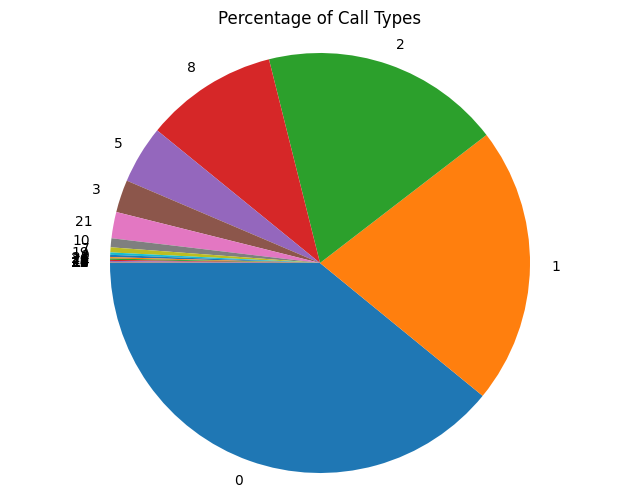

In [6]:
# Calculate the percentage of each call type
call_type_percentages = dataset['Type'].value_counts(normalize=True) * 100

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(call_type_percentages, labels=call_type_percentages.index, startangle=180)
plt.title('Percentage of Call Types')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.show()

In [7]:
np.sum(call_type_percentages[:5])

93.58906876554941

In [8]:
# Filter by types 1, 2, 3, and 4
filtered_dataset = dataset[dataset['Type'].isin([0, 1, 2, 8, 5])]

# Define the mapping dictionary
mapping = {0: 0, 1: 1, 2: 2, 8: 3, 5: 4}

# Remap values in the 'type' column
filtered_dataset.loc[:, 'Type'] = filtered_dataset['Type'].replace(mapping)

# Drop specific columns using del
columns_to_drop = [f'Wait_List_Length__{i}' for i in range(27) if i not in [0, 1, 2, 8, 5]]
for column in columns_to_drop:
    del filtered_dataset[column]

filtered_df = filtered_dataset[ 
  (filtered_dataset['Is_Served'] != 0) & 
  (filtered_dataset['Waiting_Time'] > 0)
]

In [39]:
filtered_dataset.info()

<a id="4"></a>
## <span style="color:orange">Feature Scaling</span> [⏮️](#3)[👆🏽](#0)[⏭️](#5)

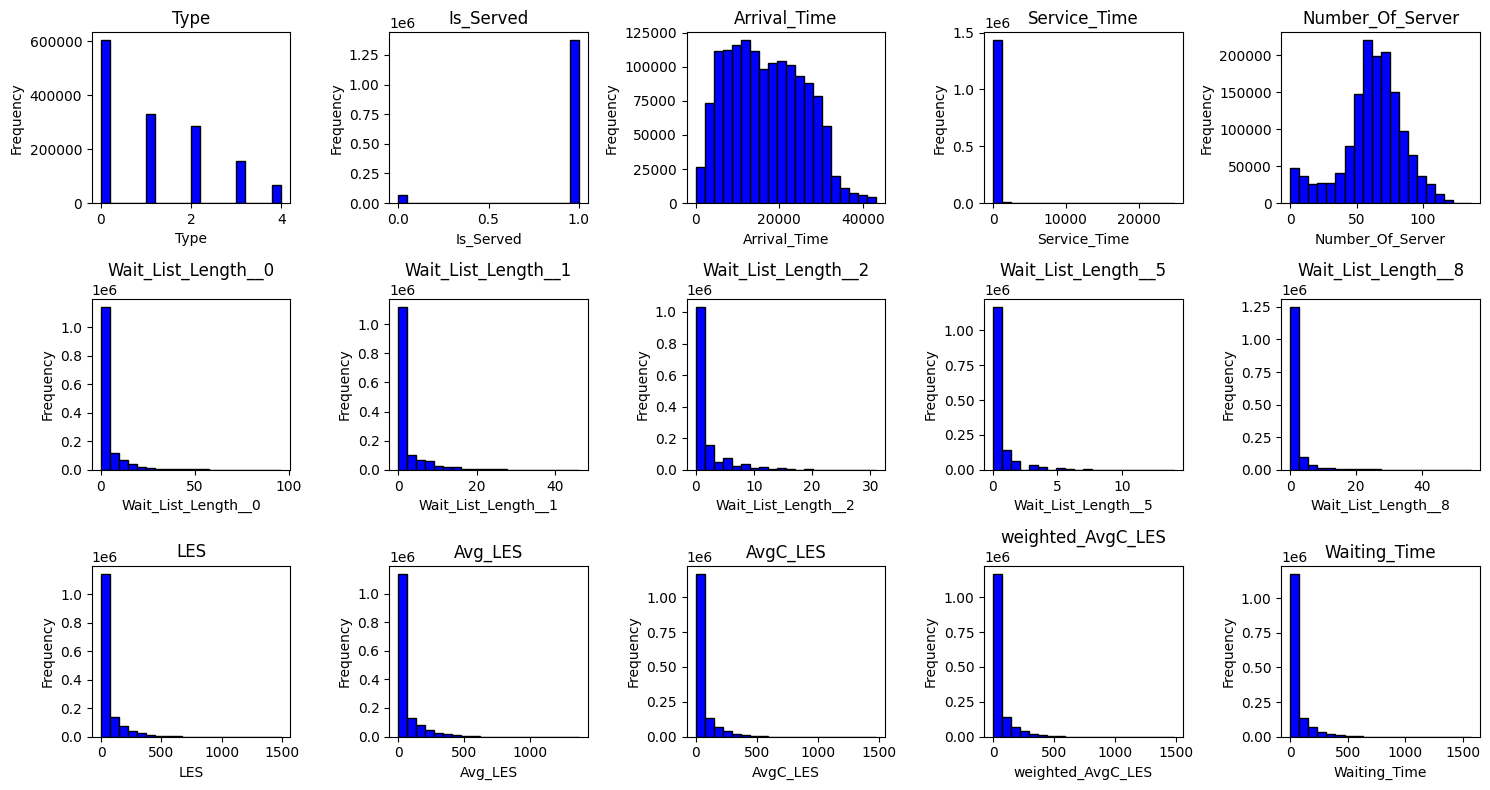

In [10]:
# Define the number of rows and columns for the subplots
num_rows = 3
num_cols = 5

# Get the feature column names (excluding the target column)
feature_columns = filtered_dataset.columns

# Calculate the number of subplots
num_subplots = len(feature_columns)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
# Iterate over feature columns and create histograms on subplots
for i, column in enumerate(feature_columns):
    if i >= num_rows * num_cols:
        break  # Stop creating subplots after filling the grid
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].hist(filtered_dataset[column], bins=20, color='blue', edgecolor='black')
    axes[row_idx, col_idx].set_title(column)
    axes[row_idx, col_idx].set_xlabel(column)
    axes[row_idx, col_idx].set_ylabel('Frequency')

# Adjust layout for subplots
plt.tight_layout()
plt.show()

In [11]:
normalized_dataset = (filtered_dataset - filtered_dataset.min()) / (filtered_dataset.max() - filtered_dataset.min())

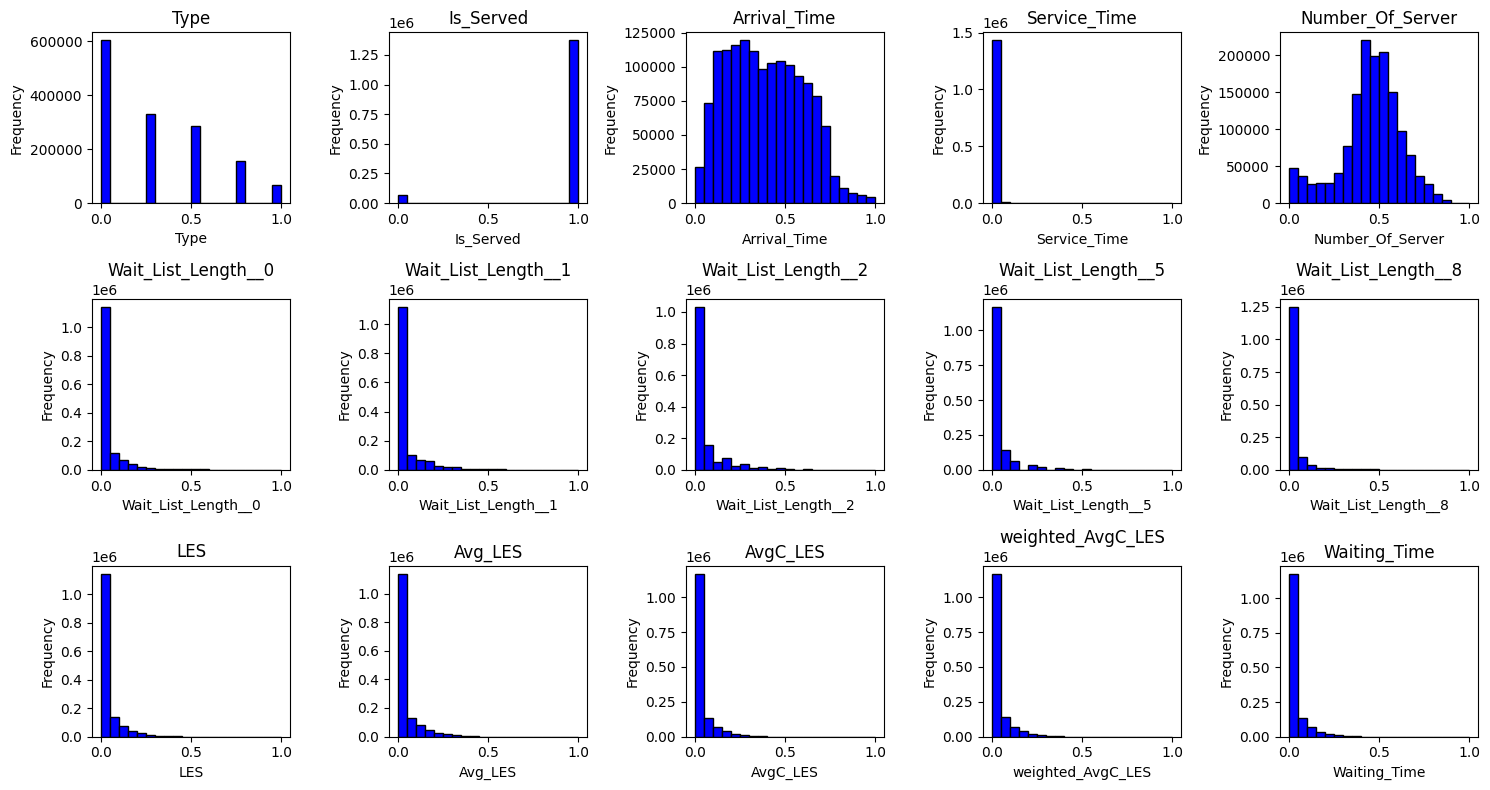

In [12]:
# Define the number of rows and columns for the subplots
num_rows = 3
num_cols = 5

# Get the feature column names (excluding the target column)
feature_columns = normalized_dataset.columns

# Calculate the number of subplots
num_subplots = len(feature_columns)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
# Iterate over feature columns and create histograms on subplots
for i, column in enumerate(feature_columns):
    if i >= num_rows * num_cols:
        break  # Stop creating subplots after filling the grid
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].hist(normalized_dataset[column], bins=20, color='blue', edgecolor='black')
    axes[row_idx, col_idx].set_title(column)
    axes[row_idx, col_idx].set_xlabel(column)
    axes[row_idx, col_idx].set_ylabel('Frequency')

# Adjust layout for subplots
plt.tight_layout()
plt.show()

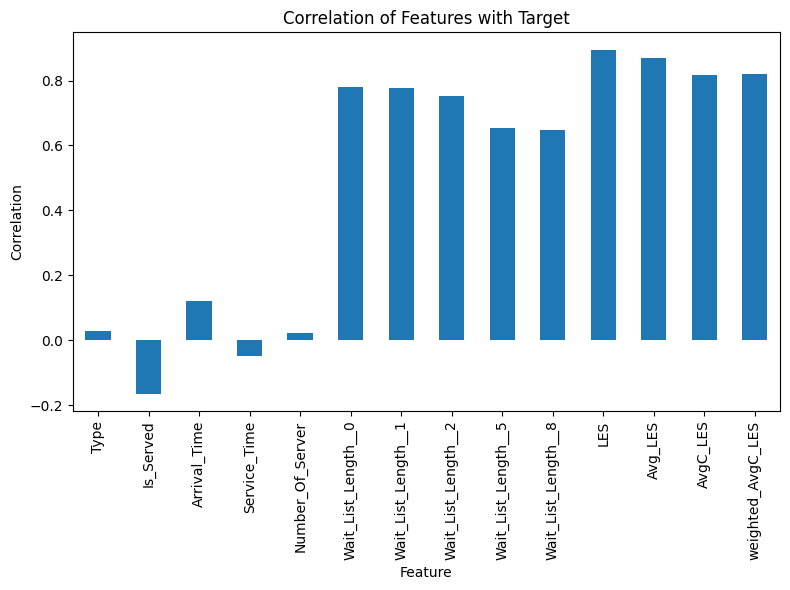

In [13]:
# Calculate correlations
correlations = normalized_dataset.corr()['Waiting_Time'].drop('Waiting_Time')  # Calculate correlations with the target and drop the target column itself

# Plot correlations
plt.figure(figsize=(8, 6))
correlations.plot(kind='bar')
plt.title('Correlation of Features with Target')
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [14]:
normalized_dataset.head()

,Type,Is_Served,Arrival_Time,Service_Time,Number_Of_Server,Wait_List_Length__0,Wait_List_Length__1,Wait_List_Length__2,Wait_List_Length__5,Wait_List_Length__8,LES,Avg_LES,AvgC_LES,weighted_AvgC_LES,Waiting_Time
0,0.50,1.0,0.084084,0.000847,0.007353,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000636
1,0.50,1.0,0.087279,0.003349,0.014706,0.0,0.0,0.0,0.0,0.0,0.001337,0.000728,0.000676,0.001351,0.000636
2,0.00,1.0,0.089177,0.006294,0.029412,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000636
3,0.25,1.0,0.090080,0.004721,0.044118,0.0,0.0,0.0,0.0,0.0,0.001337,0.000728,0.000676,0.001351,0.000636
4,0.25,1.0,0.088830,0.011136,0.029412,0.0,0.0,0.0,0.0,0.0,0.001337,0.000728,0.000676,0.001351,0.000636


In [40]:
normalized_dataset.info()

<a id="5"></a>
## <span style="color:orange">Data splitting</span> [⏮️](#4)[👆🏽](#0)[⏭️](#6)

In [16]:
# Split the dataset into train and test sets
X = normalized_dataset.drop(columns=['Waiting_Time'])  # Features
y = normalized_dataset['Waiting_Time']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1010634, 14)
X_test shape: (433129, 14)
y_train shape: (1010634,)
y_test shape: (433129,)


<a id="6"></a>
## <span style="color:orange">DL Model</span> [⏮️](#5)[👆🏽](#0)[⏭️](#7)

In [17]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

In [26]:
from tensorflow.keras import backend as K

# Define custom metric RRMSE
def rrmse(y_true, y_pred):
  mse = K.mean(K.square(y_true - y_pred))  # Mean Squared Error
  avg_wait_time = K.mean(K.square(y_true))  # Average wait time of N customers
  rrmse = K.sqrt(mse / avg_wait_time)  # Root Relative Mean Squared Error
  return rrmse * 100

In [28]:
model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(),
  loss=tf.keras.losses.MeanSquaredError(),
  metrics=[
    tf.keras.metrics.RootMeanSquaredError(),
    rrmse
  ]
)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
  X_train,
  y_train,
  validation_split=0.2,
  epochs=15
).history

<a id="7"></a>
## <span style="color:orange">Performance Evaluation</span> [⏮️](#6)[👆🏽](#0)[⏭️](#8)

In [33]:
y_pred = model.predict(X_test)

13536/13536 [==============================] - 3s 251us/step


In [34]:
# Combine X_test, y_true_df, and y_pred_df horizontally
combined_df = pd.concat(
  [
    X_test, 
    pd.DataFrame(y_test.values.reshape(-1, 1), columns=['Waiting_Time'], index=X_test.index), 
    pd.DataFrame(y_pred, columns=['Predicted_Time'], index=X_test.index)
  ],
  axis=1
)

combined_df.head()

,Type,Is_Served,Arrival_Time,Service_Time,Number_Of_Server,Wait_List_Length__0,Wait_List_Length__1,Wait_List_Length__2,Wait_List_Length__5,Wait_List_Length__8,LES,Avg_LES,AvgC_LES,weighted_AvgC_LES,Waiting_Time,Predicted_Time
362515,0.25,1.0,0.262878,0.028244,0.580882,0.0,0.000000,0.000000,0.0,0.0,0.001337,0.001019,0.000947,0.001695,0.000636,0.003288
1044525,0.75,1.0,0.124158,0.030181,0.176471,0.0,0.021739,0.000000,0.0,0.0,0.001337,0.000728,0.000676,0.001351,0.000636,0.003288
465421,0.25,1.0,0.312536,0.013073,0.588235,0.0,0.000000,0.000000,0.0,0.0,0.001337,0.001019,0.000947,0.001467,0.003181,0.003288
931096,0.50,1.0,0.687186,0.005326,0.330882,0.0,0.000000,0.064516,0.0,0.0,0.078877,0.049221,0.052062,0.047083,0.058524,0.051532
318163,0.25,1.0,0.575831,0.014082,0.426471,0.0,0.000000,0.000000,0.0,0.0,0.001337,0.000728,0.000676,0.001351,0.000636,0.003288


In [35]:
# Define custom metric RRMSE
def rrmse(y_true, y_pred):
  mse = np.mean(np.square(y_true - y_pred))  # Mean Squared Error
  avg_wait_time = np.mean(np.square(y_true)) # Average wait time of N customers
  rrmse = np.sqrt(mse / avg_wait_time)  # Root Relative Mean Squared Error
  return rrmse * 100

In [36]:
# Calculate RMSE and RRMSE for each group
grouped = combined_df.groupby('Type').apply(lambda group: {
    'LES': rrmse(group['Waiting_Time'], group['LES']),
    'Avg_LES': rrmse(group['Waiting_Time'], group['Avg_LES']),
    'AvgC_LES': rrmse(group['Waiting_Time'], group['AvgC_LES']),
    'W_AvgC_LES': rrmse(group['Waiting_Time'], group['weighted_AvgC_LES']),
    'ANN': rrmse(group['Waiting_Time'], group['Predicted_Time'])
}).reset_index()

# Convert the dictionary-like values to separate columns
normalized_data = pd.json_normalize(grouped[0])

normalized_data

,LES,Avg_LES,AvgC_LES,W_AvgC_LES,ANN
0,44.502269,51.609690,50.548024,50.122990,24.655293
1,45.593803,54.424435,53.330139,53.185670,26.624928
2,53.253891,61.611710,61.086576,60.666761,28.192417
3,49.715647,56.453244,54.785192,53.984475,25.918386
4,63.993984,68.378078,66.910578,66.953618,32.844168


<a id="8"></a> 
### <span style="color:orange"><i>Références</i></span> [⏮️](#7)[👆🏽](#0)[⏭️](#9)

Here is a reference to the [Python documentation](https://docs.python.org/).


Here are some references for more information on the libraries used:<br>
🧑🏾‍💻 [Pandas documentation](https://pandas.pydata.org/docs/) <br>
🧑🏾‍💻 [NumPy documentation](https://numpy.org/doc/stable/) <br>
🧑🏾‍💻 [Matplotlib documentation](https://matplotlib.org) <br>
🧑🏾‍💻 [Tensorflow documentation](https://www.tensorflow.org/guide?hl=fr) <br>
🧑🏾‍💻 [Sciki-learn documentation](https://scikit-learn.org/stable/) <br>

<a id="9"></a> 
### <span style="color:orange"><i>Auteur</i></span> [⏮️](#8)[👆🏽](#0)[⏭️]()

**`Auteurs`:** Mouhamadou Naby DIA & Abdou SAKHO

**`Ecole`:** Ecole Polytechnique de THIES

**`Departement`:** Genie Informatique et Telecoms

**`Niveau`:** DIC2
